In [3]:
import numpy as np
import math

import os
from os.path import expanduser
home = expanduser("~")
os.environ["OMP_NUM_THREADS"] = "1"
#import warnings
#warnings.filterwarnings("ignore")
import sys
sys.path.insert(1, '../src')
from importlib import reload

#astropy
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel,Gaussian2DKernel
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.stats import mad_std,sigma_clipped_stats
from photutils import detection

#scipy
from scipy.interpolate import pchip
from scipy import ndimage
from scipy.signal import find_peaks
from scipy.optimize import minimize,differential_evolution,basinhopping,dual_annealing,NonlinearConstraint

#matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.transforms import Bbox
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display


# NGC 6328 redshift

In [4]:
z=0.014313
arc_to_kpc=(cosmo.angular_diameter_distance(z=z)/206265).to(u.kpc)/u.arcsec
arc_to_kpc

<Quantity 0.29495281 kpc / arcsec>

# Import Data

In [5]:
import utils
cubefolder='../data/NGC6328/cubes/'
cloudsfolder='../data/NGC6328/clouds/'
datafolder='../data/NGC6328/other/'

## Cubes

In [6]:
reload(utils)

cube21_file=cubefolder+'NGC6328_CO_selfcal_20km_natural_pbcor.fits'
ucube21_file=cubefolder+'NGC6328_CO_selfcal_20km_natural.fits'
z=0.014313
CO21,CO21_total=utils.load_fits_cube(cube_file=cube21_file,ucube_file=ucube21_file,pbfile=None,
                    drop={'x':2.6,'y':4.9,'v':460},z=z,sigma=5,
                     beam=[0.296,0.220,38.624],zaxis='freq',restFreq=230.538e9,
                    debug=False,nosignalregions = [{'x0':300,'y0':600,'dx':200,'dy':500},{'x0':1200,'y0':600,'dx':200,'dy':500}])
rms=CO21.attrs['rms']

Original Data Corrected Cube shape (123, 1680, 1680)
Original Data UnCorrected Cube shape (123, 1680, 1680)
RMS Noise in area {'x0': 300, 'y0': 600, 'dx': 200, 'dy': 500} 0.0002467646215950085
RMS Noise in area {'x0': 1200, 'y0': 600, 'dx': 200, 'dy': 500} 0.00024745194844498736
Mean RMS:  0.00024710828501999795


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<Quantity 0.00499884 kpc2 / beam>

<Quantity 7.82974432e-05 1 / pix2>

## HI

In [7]:
macc_HI_Vrot=np.loadtxt(datafolder+'macc_HI_Vrot.csv',delimiter=',')
vc_HI_Vrot=np.loadtxt(datafolder+'vc_HI_Vrot.csv',delimiter=',')
V_sys=4274

min_to_kpc=(cosmo.angular_diameter_distance(0.014313)/u.radian).to(u.kpc/u.arcmin)
sec_to_kpc=(cosmo.angular_diameter_distance(0.014313)/u.radian).to(u.kpc/u.arcsec)

R_macc_HI=(macc_HI_Vrot[:,0])*u.arcmin*min_to_kpc
V_macc_HI=macc_HI_Vrot[:,1]-V_sys

R_vc_HI=(vc_HI_Vrot[:,0])*u.arcsec*sec_to_kpc
V_vc_HI=vc_HI_Vrot[:,1]-V_sys-20

Rm=np.abs(R_macc_HI.value)
Rvc=np.abs(R_vc_HI.value)
Vm_20=V_macc_HI/np.sin(np.radians(20))
Vvc_20=V_vc_HI/np.sin(np.radians(20))
HI_sigma=40
Rc=20

Rmf=Rm[(Rm>21)&(Rm<36)]
Vmf=np.abs(Vm_20[(Rm>21)&(Rm<36)])
Rvcf=Rvc[(Rvc>21)&(Rvc<36)]
Vvcf=np.abs(Vvc_20[(Rvc>21)&(Rvc<36)])

# Source detection progress

In [60]:
!rsync -uvrP mixpap@195.251.202.114:/home/mixpap/astro/ARC/notebooks/cube_fitter/*.npy ../data/NGC6328/clouds
!rsync -uvrP mixpap@195.251.202.114:/home/mixpap/astro/ARC/notebooks/cube_fitter/3ddetM.out .
!rsync -uvrP mixpap@195.251.202.114:/home/mixpap/astro/ARC/notebooks/cube_fitter/3ddetM25.out .

receiving incremental file list
A3d.npy
          3,152 100%    3.01MB/s    0:00:00 (xfr#1, to-chk=18/19)
V3d.npy
          3,152 100%    3.01MB/s    0:00:00 (xfr#2, to-chk=12/19)
X3d.npy
          3,152 100%    3.01MB/s    0:00:00 (xfr#3, to-chk=10/19)
Y3d.npy
          3,152 100%    3.01MB/s    0:00:00 (xfr#4, to-chk=8/19)
a3d.npy
          3,152 100%    3.01MB/s    0:00:00 (xfr#5, to-chk=7/19)
b3d.npy
          3,152 100%    3.01MB/s    0:00:00 (xfr#6, to-chk=6/19)
c3d.npy
          3,152 100%    3.01MB/s    0:00:00 (xfr#7, to-chk=5/19)
sv3d.npy
          3,152 100%    3.01MB/s    0:00:00 (xfr#8, to-chk=4/19)

sent 368 bytes  received 14,869 bytes  10,158.00 bytes/sec
total size is 5,148,858  speedup is 337.92
receiving incremental file list

sent 20 bytes  received 47 bytes  44.67 bytes/sec
total size is 66,791  speedup is 996.88
receiving incremental file list
3ddetM25.out
         75,651 100%   18.04MB/s    0:00:00 (xfr#1, to-chk=0/1)

sent 43 bytes  received 75,759 bytes  50,534

In [72]:
!rsync -uvrP mixpap@195.251.202.114:/home/mixpap/astro/ARC/notebooks/cube_fitter/3ddetM25.out .

receiving incremental file list
3ddetM25.out
         75,787 100%   72.28MB/s    0:00:00 (xfr#1, to-chk=0/1)

sent 697 bytes  received 714 bytes  940.67 bytes/sec
total size is 75,787  speedup is 53.71


In [79]:

file="3ddetM.out"

In [80]:
finished=[]
with open(file, "r") as fp:
    lines = [line for line in fp if 'Found' in line]
    for line in lines:
        finished.append(line.split()[4])

In [81]:
tried=[]
with open(file, "r") as fp:
    lines = [line for line in fp if 'Trying' in line]
    for line in lines:
        #print(int(line.split()[11]),int(line.split()[11])<300)
        if int(line.split()[11])<300:
            tried.append(line.split()[3])

In [82]:

X3d=np.array([])
Y3d=np.array([])
A3d=np.array([])
V3d=np.array([])
a3d=np.array([])
b3d=np.array([])
c3d=np.array([])
Sv3d=np.array([])
with open(file, "r") as fp:
    lines = [line for line in fp if 'Results' in line]
    for line in lines:
        A3d=np.append(A3d,float(line.split()[4]))
        X3d=np.append(X3d,float(line.split()[5][3:-1]))
        Y3d=np.append(Y3d,float(line.split()[6][3:]))
        V3d=np.append(V3d,float(line.split()[7][3:]))
        a3d=np.append(a3d,float(line.split()[8][3:-1]))
        b3d=np.append(b3d,float(line.split()[9][3:-1]))
        c3d=np.append(c3d,float(line.split()[10][3:-1]))
        Sv3d=np.append(Sv3d,float(line.split()[11][3:]))
        #print(float(line.split()[8][3:-1]))
        # if int(line.split()[11])<300:
        #     tried.append(line.split()[3])
print(A3d.shape)       
R3d= np.sqrt(X3d**2+Y3d**2)
PHI3d=np.arctan2(Y3d,X3d)

(262,)


In [83]:
Xcloud=np.load(cloudsfolder+'X3d.npy')
Ycloud=np.load(cloudsfolder+'Y3d.npy')
Vcloud=np.load(cloudsfolder+'V3d.npy')
acloud=np.load(cloudsfolder+'a3d.npy')
bcloud=np.load(cloudsfolder+'b3d.npy')
ccloud=np.load(cloudsfolder+'c3d.npy')
Svcloud=np.load(cloudsfolder+'sv3d.npy')
Acloud=np.load(cloudsfolder+'A3d.npy')

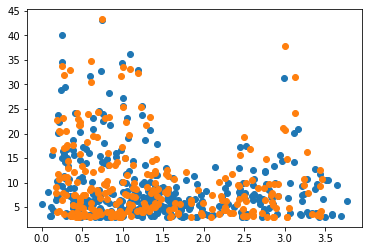

In [84]:
plt.plot(np.sqrt(Xcloud**2+Ycloud**2),Acloud/rms,'o')
plt.plot(R3d,A3d,'o')

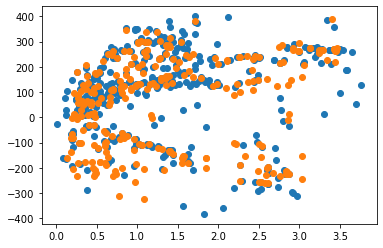

In [85]:
plt.plot(np.sqrt(Xcloud**2+Ycloud**2),Vcloud,'o')
plt.plot(R3d,V3d,'o')

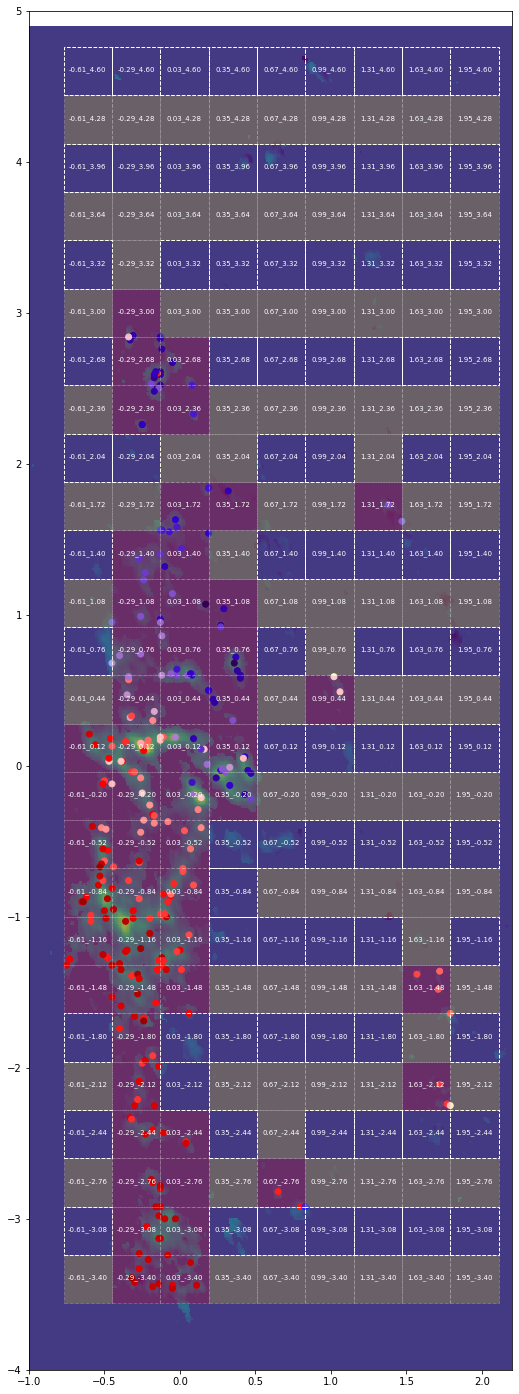

In [86]:
Rg=0.4
xgrid=np.arange(-0.8,1,2*Rg)
ygrid=np.arange(-4.,3.2,2*Rg)

Rg=0.5
xgrid=[-0.2]
ygrid=[-3.1]

Rg=0.12
xgrid=np.arange(-0.8,1,2*Rg)
ygrid=np.arange(-4.,3.2,2*Rg)

Rg=0.16
xgrid=np.arange(-0.61,2,2*Rg)
ygrid=np.arange(-3.4,4.8,2*Rg)
# Rg=0.06
# xgrid=np.arange(-0.5,-0.3,2*Rg)
# ygrid=np.arange(-1,0,2*Rg)

# Rg=0.16
# xgrid=np.arange(-0.61,2,2*Rg)
# ygrid=np.arange(-3.4,4.8,2*Rg)
    
fig,ax=plt.subplots(1,1,figsize=(20,25))
ax.pcolormesh(CO21.x,CO21.y,np.nansum(CO21['cube'],axis=0),shading='auto')
ax.set(aspect=1,xlim=[-1,2.2],ylim=[-4,5])
for xx in xgrid:
    for yy in ygrid:
        name=f"{xx:.2f}_{yy:.2f}"
        ax.text(xx,yy,name,color='white',fontsize=7,horizontalalignment='center')
        if name in finished:
            #print(name)
            ax.add_patch(plt.Rectangle((xx-Rg, yy-Rg), 2*Rg, 2*Rg,fc='red',ls="--",color='white',alpha=0.2))#, ls="--", ec="c", fc="None",transform=ax.transAxes))
        elif name in tried:
            ax.add_patch(plt.Rectangle((xx-Rg, yy-Rg), 2*Rg, 2*Rg,fc='yellow',ls="--",color='white',alpha=0.2))#, ls="--", ec="c", fc="None",transform=ax.transAxes))
        else:
            ax.add_patch(plt.Rectangle((xx-Rg, yy-Rg), 2*Rg, 2*Rg,fc='None',ls="--",color='white'))#, ls="--", ec="c", fc="None",transform=ax.transAxes))

#ax.scatter(Xcloud,Ycloud,c=Vcloud,s=(Acloud/rms)*2,cmap='seismic',vmin=-400,vmax=400,alpha=0.8)
ax.scatter(X3d,Y3d,c=V3d,vmin=-350,vmax=350,cmap='seismic')

In [78]:
Sv3d.shape

(251,)

/home/astromix/miniconda3/envs/MAYA/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


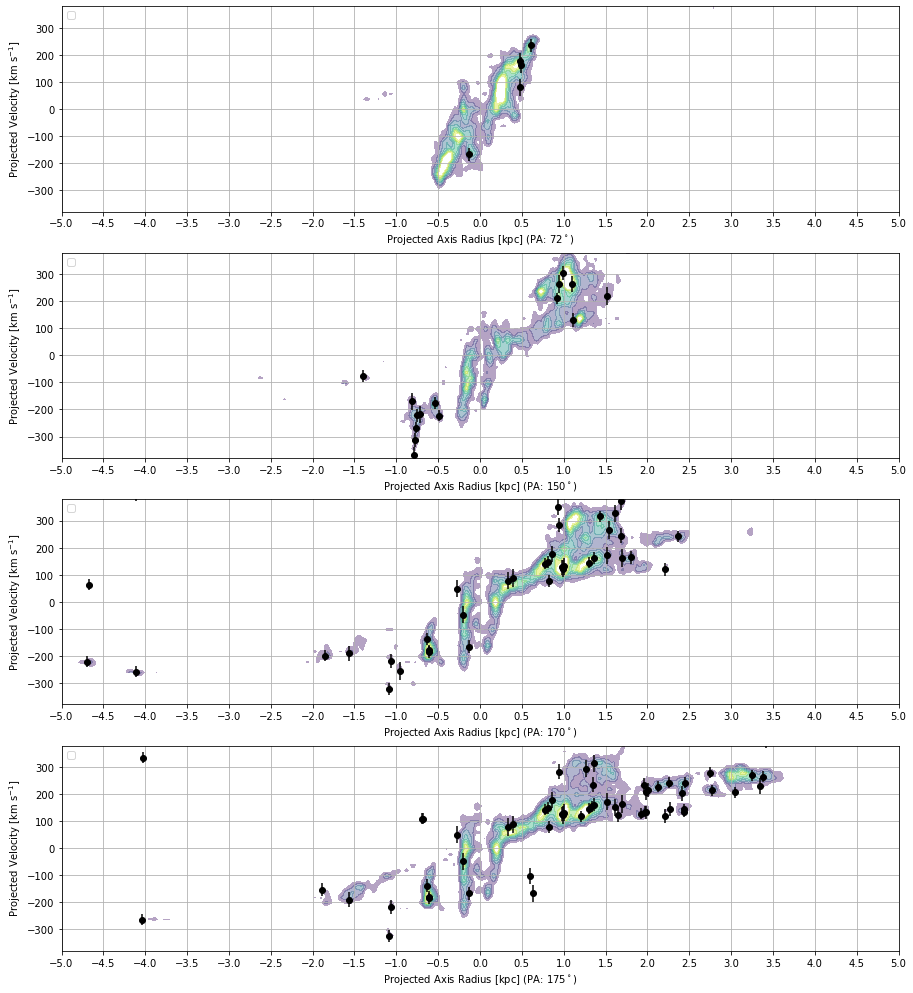

In [70]:
cube_total=CO21_total
slit=0.2
papvds=[72,150,170,175]
#papvds=[150,160]
ithick = int(round(slit/cube_total.attrs['dx']))
ixc = round(cube_total.dims['x']/2)
y=cube_total.y.data
v=cube_total.v.data
Npas=len(papvds)
lwd=3
lwd_n=1
alpha=0.1
levels=np.arange(2,10,1)
xlim=[-5,5]
vlim=[-380,380]
figsize=(20,10)
dxticks=0.5
dvticks=100
        
figsize=(15*(xlim[1]-xlim[0])/10,2.*Npas*(vlim[1]-vlim[0])/350) #if figsize == 'auto' else figsize
fig,ax=plt.subplots(nrows=Npas,figsize=figsize)#(20,6*len(papvds)))
for j,papvd in enumerate(papvds):
    rotcube=ndimage.interpolation.rotate(cube_total['cube'].fillna(0).data,papvd, axes=(1, 2), reshape=False)
    cubeslice = np.nansum(rotcube[:,:,ixc-ithick:ixc+ithick],axis=2)
    rotmadmap=ndimage.interpolation.rotate(cube_total['madcube'].fillna(0).data, papvd, axes=(1, 2), reshape=False)
    pvdmadmap=np.nansum(rotmadmap[:,:,ixc-ithick:ixc+ithick],axis=2)
    #pvdmadmap=np.sqrt(np.nansum(rotmadmap[:,:,ixc-ithick:ixc+ithick]**2,axis=2))
    pvd_cube=cubeslice/pvdmadmap;  #pvdlvs[0]
    pvd_cube=np.where(pvd_cube>=0,pvd_cube,np.nan)
    ax[j].contourf(y,v,pvd_cube,levels=levels,alpha=0.4,cmap='viridis')
    phi=np.radians(papvd+90)
    cospa=np.cos(phi)
    sinpa=np.sin(phi)
    tanpa=np.tan(phi)
    
    # Yslit_l=slit/(2*cospa)+Xcloud*tanpa
    # Yslit_u=-slit/(2*cospa)+Xcloud*tanpa

    # XX_s=Xcloud[(Yslit_l<Ycloud)&(Ycloud<Yslit_u)]
    # YY_s=Ycloud[(Yslit_l<Ycloud)&(Ycloud<Yslit_u)]
    # VV_s=Vcloud[(Yslit_l<Ycloud)&(Ycloud<Yslit_u)]
    # AA_s=Acloud[(Yslit_l<Ycloud)&(Ycloud<Yslit_u)]
    # Sv=Svcloud[(Yslit_l<Ycloud)&(Ycloud<Yslit_u)]
    # #F_s=F[(Yslit_l<Ycloud)&(Ycloud<Yslit_u)]

    # PHI_s=np.arctan2(YY_s,XX_s)
    # RR_s=np.sqrt(XX_s**2+YY_s**2)

    # ax[j].errorbar(RR_s*np.sign(-np.cos(PHI_s)),VV_s,yerr=Sv,fmt='o',color='black')


    Yslit_l3=slit/(2*cospa)+X3d*tanpa
    Yslit_u3=-slit/(2*cospa)+X3d*tanpa

    XX_s=X3d[(Yslit_l3<Y3d)&(Y3d<Yslit_u3)]
    YY_s=Y3d[(Yslit_l3<Y3d)&(Y3d<Yslit_u3)]
    VV_s=V3d[(Yslit_l3<Y3d)&(Y3d<Yslit_u3)]
    Sv=Sv3d[(Yslit_l3<Y3d)&(Y3d<Yslit_u3)]
    #F_s=F[(Yslit_l<Ycloud)&(Ycloud<Yslit_u)]

    PHI_s=np.arctan2(YY_s,XX_s)
    RR_s=np.sqrt(XX_s**2+YY_s**2)

    ax[j].errorbar(RR_s*np.sign(-np.cos(PHI_s)),VV_s,yerr=Sv,fmt='o',color='black')

    ax[j].xaxis.set_ticks(np.arange(-8,8+dxticks,dxticks))
    ax[j].yaxis.set_ticks(np.arange(-600,600,dvticks))
    ax[j].set(xlim=xlim,ylim=vlim,xlabel=r'Projected Axis Radius [kpc] (PA: ${}^\circ$)'.format(papvd),ylabel=r'Projected Velocity [km s$^{-1}$]')
    ax[j].grid(True,which='both')
    ax[j].legend(loc=2)

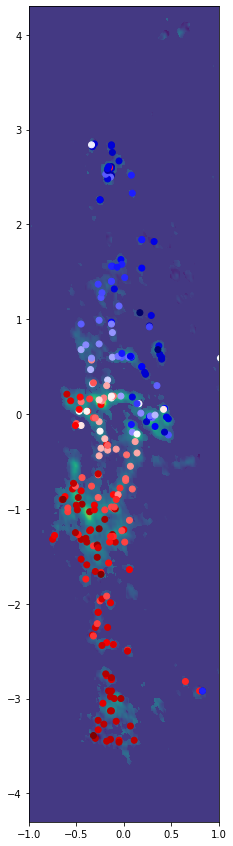

In [216]:
oo=(Xcloud>-0.13)&(Xcloud<0.19)&(Ycloud> -0.04)&(Ycloud<0.28)
# X3d=np.array([0.09,0.16,-0.13,0.14,0.18,-0.03,-0.11])
# Y3d=np.array([0.18,0.11,0.17,0.11,0.01,0.19,0.19])
# V3d=np.array([-203,-3,12,-138,-81,-68,95])
# a3d=np.array([186,216,265,505,268,400,314])
# b3d=np.array([-8.5,-192,-106,541,212,70,-252])
# c3d=np.array([605,160,534,300,500,613,328])
# s3d=np.array([40,25,32,33,22,39,32])
# A3d=np.array([12,4,21,8,9,23,4])
from scipy.optimize import fsolve,least_squares,minimize

def equations(p,a,b,c):
    sx, sy,t = p
    return np.array([a-np.cos(t)**2/sx**2-np.sin(t)**2/sy**2,b-np.sin(2*t)/sx**2-np.sin(2*t)/sy**2,c-np.sin(t)**2/sx**2-np.cos(t)**2/sy**2])
Sx3d=np.array([])
Sy3d=np.array([])
T3d=np.array([])

for a,b,c in zip(a3d,b3d,c3d):
    # sx, sy , t  =  fsolve(equations, (1, 1,1),args=(a,b,c))
    res=least_squares(equations, x0=[0.1, 0.1,1], args=(a,b,c))#,bounds=[[0,1],[0,1],[0,np.pi]] )
    sx, sy , t  = res.x 
    Sx3d=np.append(Sx3d,sx)
    Sy3d=np.append(Sy3d,sy)
    T3d=np.append(T3d,t)
Sx3d=np.abs(Sx3d)
Sy3d=np.abs(Sy3d)
T3d=np.degrees(T3d)
from matplotlib.patches import Ellipse
fig,ax=plt.subplots(1,1,figsize=(15,15))
ax.pcolormesh(CO21.x,CO21.y,np.nansum(CO21['cube'],axis=0),shading='auto')
ax.set(aspect=1,xlim=[-1,1],ylim=[-4.3,4.3])
# norm = mpl.colors.Normalize(vmin=-350, vmax=350)
# smap = mpl.cm.ScalarMappable(norm=None, cmap='seismic')
# CdV=smap.to_rgba(V3d)

norm = mpl.colors.Normalize(vmin=0, vmax=35)
smap = mpl.cm.ScalarMappable(norm=None, cmap='magma')
CdV=smap.to_rgba(A3d)
ax.scatter(X3d,Y3d,c=V3d,vmin=-350,vmax=350,cmap='seismic')
# for x3d,y3d,sx3d,sy3d,t3d,cdv in zip(X3d,Y3d,Sx3d,Sy3d,T3d,CdV):
#     el=Ellipse((x3d,y3d),2*sx3d,2*sy3d,angle=t3d,color=cdv,alpha=0.5)
#     ax.add_patch(el)

## Calculate Sx,Sy

In [30]:
from scipy.optimize import fsolve

In [ ]:
a3d

In [42]:
def equations(p,a,b,c):
    sx, sy,t = p
    return np.array([a-np.cos(t)**2/sx**2-np.sin(t)**2/sy**2,b-np.sin(2*t)/sx**2-np.sin(2*t)/sy**2,c-np.sin(t)**2/sx**2-np.cos(t)**2/sy**2])

Sx3d=np.array([])
Sy3d=np.array([])
T3d=np.array([])
for a,b,c in zip(a3d,b3d,c3d):
    sx, sy , t  =  fsolve(equations, (0.05, 0.05,1),args=(a,b,c))
    #res=least_squares(equations, x0=[0.1, 0.1,1], args=(a,b,c))#,bounds=[[0,1],[0,1],[0,np.pi]] )
    #sx, sy , t  = res.x 
    Sx3d=np.append(Sx3d,sx)
    Sy3d=np.append(Sy3d,sy)
    T3d=np.append(T3d,t)
Sx3d=np.abs(Sx3d)
Sx3d[Sx3d>0.12]=0.12
Sy3d=np.abs(Sy3d)
Sy3d[Sy3d>0.12]=0.12
T3d=np.degrees(T3d)

fig,ax=plt.subplots(1,1,figsize=(15,15))
ax.pcolormesh(CO21.x,CO21.y,np.nansum(CO21['cube'],axis=0),shading='auto')
ax.set(aspect=1,xlim=[-1,1],ylim=[-2,2])
# norm = mpl.colors.Normalize(vmin=-350, vmax=350)
# smap = mpl.cm.ScalarMappable(norm=None, cmap='seismic')
# CdV=smap.to_rgba(V3d)

norm = mpl.colors.Normalize(vmin=-350, vmax=350)
smap = mpl.cm.ScalarMappable(norm=None, cmap='seismic')
CdV=smap.to_rgba(Vcloud)

for x3d,y3d,sx3d,sy3d,t3d,cdv in zip(X3d,Y3d,Sx3d,Sy3d,T3d,CdV):
    el=Ellipse((x3d,y3d),sx3d,sy3d,angle=t3d,color=cdv,alpha=0.5)
    ax.add_patch(el)

/home/astromix/miniconda3/envs/MAYA/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/astromix/miniconda3/envs/MAYA/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


NameError: name 'Ellipse' is not defined

In [203]:
import sympy as sm

In [208]:
aas, bs, cs,ts,sxs,sys = sm.symbols('a, b, c,t,sx,sy',real=True, positive=True)


In [212]:
eq=[aas-sm.cos(ts)**2/sxs**2-sm.sin(ts)**2/sys**2,bs-sm.sin(2*ts)/sxs**2-sm.sin(2*ts)/sys**2,cs-sm.sin(ts)**2/sxs**2-sm.cos(ts)**2/sys**2]

In [ ]:

sm.solve(eq,(ts,sxs,sys),minimal=True)

# Fitter
## Parameters

In [14]:
sys.path.insert(1, '../scripts/fitters')
import p_six
import model_creation

In [15]:
reload(model_creation)
six_dic=model_creation.prepare_params(p_six.dic)
R_d = np.arange(0.01,5.2,0.05)
dR_d=0.08/2
bounds=six_dic['bounds']#np.array(bounds)
params0=six_dic['params0']

Parameter logM has index 12
Parameter a has index 13
Parameter logMvir has index 14
PA parameters have indexes [0:6]
Inc parameters have indexes [6:12]
Total Parameters we are going to fit 15


In [16]:
def get_RES(X,Y,V,R,PHI,params,disks_f,R_d,dR_d,dic,epsilon_v=30,dV0=500,delta_v=30,da=3):
    #Phi_d,I_d,Vc_d,tani2s,vsinis=make_disks(params,Rpa,Ri,R_d,params_dic)
    R_d,I_d,Phi_d,Vc_d,tani2s,vsinis,tanI12,tanI22=disks_f(params,R_d,dR_d,dic)
    flag=[False]*X.shape[0]
    Z=np.array([np.nan]*X.shape[0])
    dV=np.array([dV0]*X.shape[0])

    #phis=np.linspace(0,2*np.pi,1000)
    #vvv=np.linspace(-400,400,500)
    #rms=cube.attrs['rms']
    for k,(x,y,v,r,phi) in enumerate(zip(X,Y,V,R,PHI)):
        dvi_min=dV0
        for m,(rd,vcd,i_d,phi_d,tani2,vsini,tani12,tani22) in enumerate(zip(R_d,Vc_d,I_d,Phi_d,tani2s,vsinis,tanI12,tanI22)):

            rell1=(rd-dR_d)/(1+tani12*np.cos(phi-phi_d)**2)**0.5#self.rR(phi,phi0,i1,R-dR)
            rell2=(rd+dR_d)/(1+tani22*np.cos(phi-phi_d)**2)**0.5#self.rR(phi,phi0,i2,R+dR)

            if (r>=rell1) and (r<=rell2):

                rell=rd/(1+tani2*np.cos(phi-phi_d)**2)**0.5# center ellipse of the ring
                drell=r-rell #distance from the center of the ring
                #r_t=rd/(1+tani2*np.cos(phi-phi_d)**2)**0.5 #corrected distance of the cloud assigned to the disk. if not corrected then due to thickness of the ring z wil be wrong
                zs=np.sign(-math.tan(i_d)*(x*math.cos(phi_d)+y*math.sin(phi_d))) #sign of the z position
                zz=math.sqrt((rd+drell)**2-r**2)*zs # z position of the cloud if it is assigned on this disk. 

                Vd_sky=vsini*np.sin(phi-phi_d)/(1 +tani2*np.cos(phi-phi_d)**2)**0.5
                #Vs=np.sort(np.abs(Vd_sky-v))
                dvi=np.abs(Vd_sky-v)
                if dvi<dvi_min:
                    dvi_min=dvi
                    dV[k]=Vd_sky-v
                    Z[k]=zz

                flag[k]=flag[k] | (dvi<epsilon_v)
                #dV[k]=np.nanmin([dV[k],dv],axis=0)
                #idv=np.nanargmin([np.abs(dV[k]),np.abs(dv)],axis=0)
                #dV[k]=np.array([[dV[k][j],dv[j]][idv[j]] for j in range(len(v))])#np.nanmin([dV[k],dv],axis=0)
                #Z[k]=np.array([[Z[k][j],zz][idv[j]] for j in range(len(v))])
    return flag,Z,dV

In [97]:
def likelihood_V(params,X,Y,V,R,PHI,disks_f,R_d,dR_d,dic,dV0=500,delta_v=30):
    #Phi_d,I_d,Vc_d,tani2s,vsinis=make_disks(params,Rpa,Ri,R_d,params_dic)
    R_d,I_d,Phi_d,Vc_d,tani2s,vsinis,tanI12,tanI22=disks_f(params,R_d,dR_d,dic)
    #flag=[False]*X.shape[0]
    #Z=np.array([np.nan]*X.shape[0])
    dV=np.array([dV0]*X.shape[0])

    #phis=np.linspace(0,2*np.pi,1000)
    #vvv=np.linspace(-400,400,500)
    #rms=cube.attrs['rms']
    for k,(x,y,v,r,phi) in enumerate(zip(X,Y,V,R,PHI)):
        dvi_min=dV0
        for m,(rd,vcd,i_d,phi_d,tani2,vsini,tani12,tani22) in enumerate(zip(R_d,Vc_d,I_d,Phi_d,tani2s,vsinis,tanI12,tanI22)):

            rell1=(rd-dR_d)/(1+tani12*np.cos(phi-phi_d)**2)**0.5#self.rR(phi,phi0,i1,R-dR)
            rell2=(rd+dR_d)/(1+tani22*np.cos(phi-phi_d)**2)**0.5#self.rR(phi,phi0,i2,R+dR)

            if (r>=rell1) and (r<=rell2):

                # rell=rd/(1+tani2*np.cos(phi-phi_d)**2)**0.5# center ellipse of the ring
                # drell=r-rell #distance from the center of the ring
                # #r_t=rd/(1+tani2*np.cos(phi-phi_d)**2)**0.5 #corrected distance of the cloud assigned to the disk. if not corrected then due to thickness of the ring z wil be wrong
                # zs=np.sign(-math.tan(i_d)*(x*math.cos(phi_d)+y*math.sin(phi_d))) #sign of the z position
                # zz=math.sqrt((rd+drell)**2-r**2)*zs # z position of the cloud if it is assigned on this disk. 

                Vd_sky=vsini*np.sin(phi-phi_d)/(1 +tani2*np.cos(phi-phi_d)**2)**0.5
                #Vs=np.sort(np.abs(Vd_sky-v))
                dvi=np.abs(Vd_sky-v)
                if dvi<dvi_min:
                    dvi_min=dvi
                    dV[k]=Vd_sky-v
                    #Z[k]=zz

                #flag[k]=flag[k] | (dvi<epsilon_v)
                #dV[k]=np.nanmin([dV[k],dv],axis=0)
                #idv=np.nanargmin([np.abs(dV[k]),np.abs(dv)],axis=0)
                #dV[k]=np.array([[dV[k][j],dv[j]][idv[j]] for j in range(len(v))])#np.nanmin([dV[k],dv],axis=0)
                #Z[k]=np.array([[Z[k][j],zz][idv[j]] for j in range(len(v))])
    return 0.5*np.sum(dV**2)/delta_v**2
def likelihood_Vm(params,X,Y,V,R,PHI,disks_f,R_d,dR_d,dic,dV0=500,delta_v=30):
    #Phi_d,I_d,Vc_d,tani2s,vsinis=make_disks(params,Rpa,Ri,R_d,params_dic)
    R_d,I_d,Phi_d,Vc_d,tani2s,vsinis,tanI12,tanI22=disks_f(params,R_d,dR_d,dic)
    #flag=[False]*X.shape[0]
    #Z=np.array([np.nan]*X.shape[0])
    dV=np.array([dV0]*X.shape[0])

    #phis=np.linspace(0,2*np.pi,1000)
    #vvv=np.linspace(-400,400,500)
    #rms=cube.attrs['rms']
    for k,(x,y,v,r,phi) in enumerate(zip(X,Y,V,R,PHI)):
        dvi_min=dV0
        for m,(rd,vcd,i_d,phi_d,tani2,vsini,tani12,tani22) in enumerate(zip(R_d,Vc_d,I_d,Phi_d,tani2s,vsinis,tanI12,tanI22)):

            rell1=(rd-dR_d)/(1+tani12*np.cos(phi-phi_d)**2)**0.5#self.rR(phi,phi0,i1,R-dR)
            rell2=(rd+dR_d)/(1+tani22*np.cos(phi-phi_d)**2)**0.5#self.rR(phi,phi0,i2,R+dR)

            if (r>=rell1) and (r<=rell2):

                # rell=rd/(1+tani2*np.cos(phi-phi_d)**2)**0.5# center ellipse of the ring
                # drell=r-rell #distance from the center of the ring
                # #r_t=rd/(1+tani2*np.cos(phi-phi_d)**2)**0.5 #corrected distance of the cloud assigned to the disk. if not corrected then due to thickness of the ring z wil be wrong
                # zs=np.sign(-math.tan(i_d)*(x*math.cos(phi_d)+y*math.sin(phi_d))) #sign of the z position
                # zz=math.sqrt((rd+drell)**2-r**2)*zs # z position of the cloud if it is assigned on this disk. 

                Vd_sky=vsini*np.sin(phi-phi_d)/(1 +tani2*np.cos(phi-phi_d)**2)**0.5
                #Vs=np.sort(np.abs(Vd_sky-v))
                dvi=np.abs(Vd_sky-v)
                if dvi<dvi_min:
                    dvi_min=dvi
                    dV[k]=Vd_sky-v
                    #Z[k]=zz

                #flag[k]=flag[k] | (dvi<epsilon_v)
                #dV[k]=np.nanmin([dV[k],dv],axis=0)
                #idv=np.nanargmin([np.abs(dV[k]),np.abs(dv)],axis=0)
                #dV[k]=np.array([[dV[k][j],dv[j]][idv[j]] for j in range(len(v))])#np.nanmin([dV[k],dv],axis=0)
                #Z[k]=np.array([[Z[k][j],zz][idv[j]] for j in range(len(v))])
    return -0.5*np.sum(dV**2)/delta_v**2

In [134]:
def posterior(params,X,Y,V,R,PHI,disks_f,R_d,dR_d,dic,dV0=500,delta_v=30):
    prior = -0.5*np.sum((params-dic['p0'])**2/dic['dp']**2)
    like=likelihood_Vm(params,X,Y,V,R,PHI,disks_f,R_d,dR_d,dic,dV0,delta_v)
    return prior+like,prior,like


In [135]:
posterior(params,X3d,Y3d,V3d,R3d,PHI3d,p_six.make_disks,R_d,dR_d,six_dic,400,60)

../scripts/fitters/p_six.py:74: RuntimeWarning: invalid value encountered in sqrt
  i1=np.arctan((k1*k1-1)**0.5)#np.arctan(np.sqrt(k1**2-1))


(-129.1764537572452, -6.234648201689637, -122.94180555555556)

In [136]:
import emcee
def mcmc_fit(posterior,walkers,nsteps,cores,bounds,args=None,backend=None):
    ndim = bounds.shape[0] # How many parameters to fit
    nwalkers = ndim*walkers#60#16#4 # Minimum of 2 walkers per free parameter
    print(ndim,nwalkers,nwalkers/cores)
    pos = [np.random.uniform(bounds[:,0],bounds[:,1]) for i in range(nwalkers)]
    if backend is not None:
        backend = emcee.backends.HDFBackend(backend)
        backend.reset(nwalkers, ndim)
    #print(kwargs)
    if cores>1:
        with Pool(cores) as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior,pool=pool,backend=backend,args=args,
                                            moves=[(emcee.moves.DEMove(),0.75),(emcee.moves.DESnookerMove(),0.25),(emcee.moves.StretchMove(),0.25),])# Setup the sampler
            result=sampler.run_mcmc(pos, nsteps,progress=True)
    else:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior,backend=backend,args=args,
                                        moves=[(emcee.moves.DEMove(),0.1),(emcee.moves.DESnookerMove(),0.1),(emcee.moves.StretchMove(),0.8),])# Setup the sampler
        result=sampler.run_mcmc(pos, nsteps,progress=True)
    #samples = sampler.chain[:, 0:, :].reshape((-1, ndim))
    return sampler

In [139]:
sample=mcmc_fit(posterior,5,700,1,six_dic['bounds'],args=[X3d,Y3d,V3d,R3d,PHI3d,p_six.make_disks,R_d,dR_d,six_dic,400,40],backend=None)

15 75 75.0


100%|██████████| 700/700 [2:38:15<00:00, 13.56s/it]


In [141]:
burnin=80
log_prob_samples = sample.get_log_prob(flat=True,discard=burnin)
chains= sample.get_chain()
L=sample.get_log_prob()
tau = sample.get_autocorr_time(tol=0)
nsteps,nwalkers,ndim=chains.shape
samples = sample.get_chain(flat=True,discard=burnin) 
autocorr=[]
for n in range(nsteps): autocorr.append(np.mean(tau))

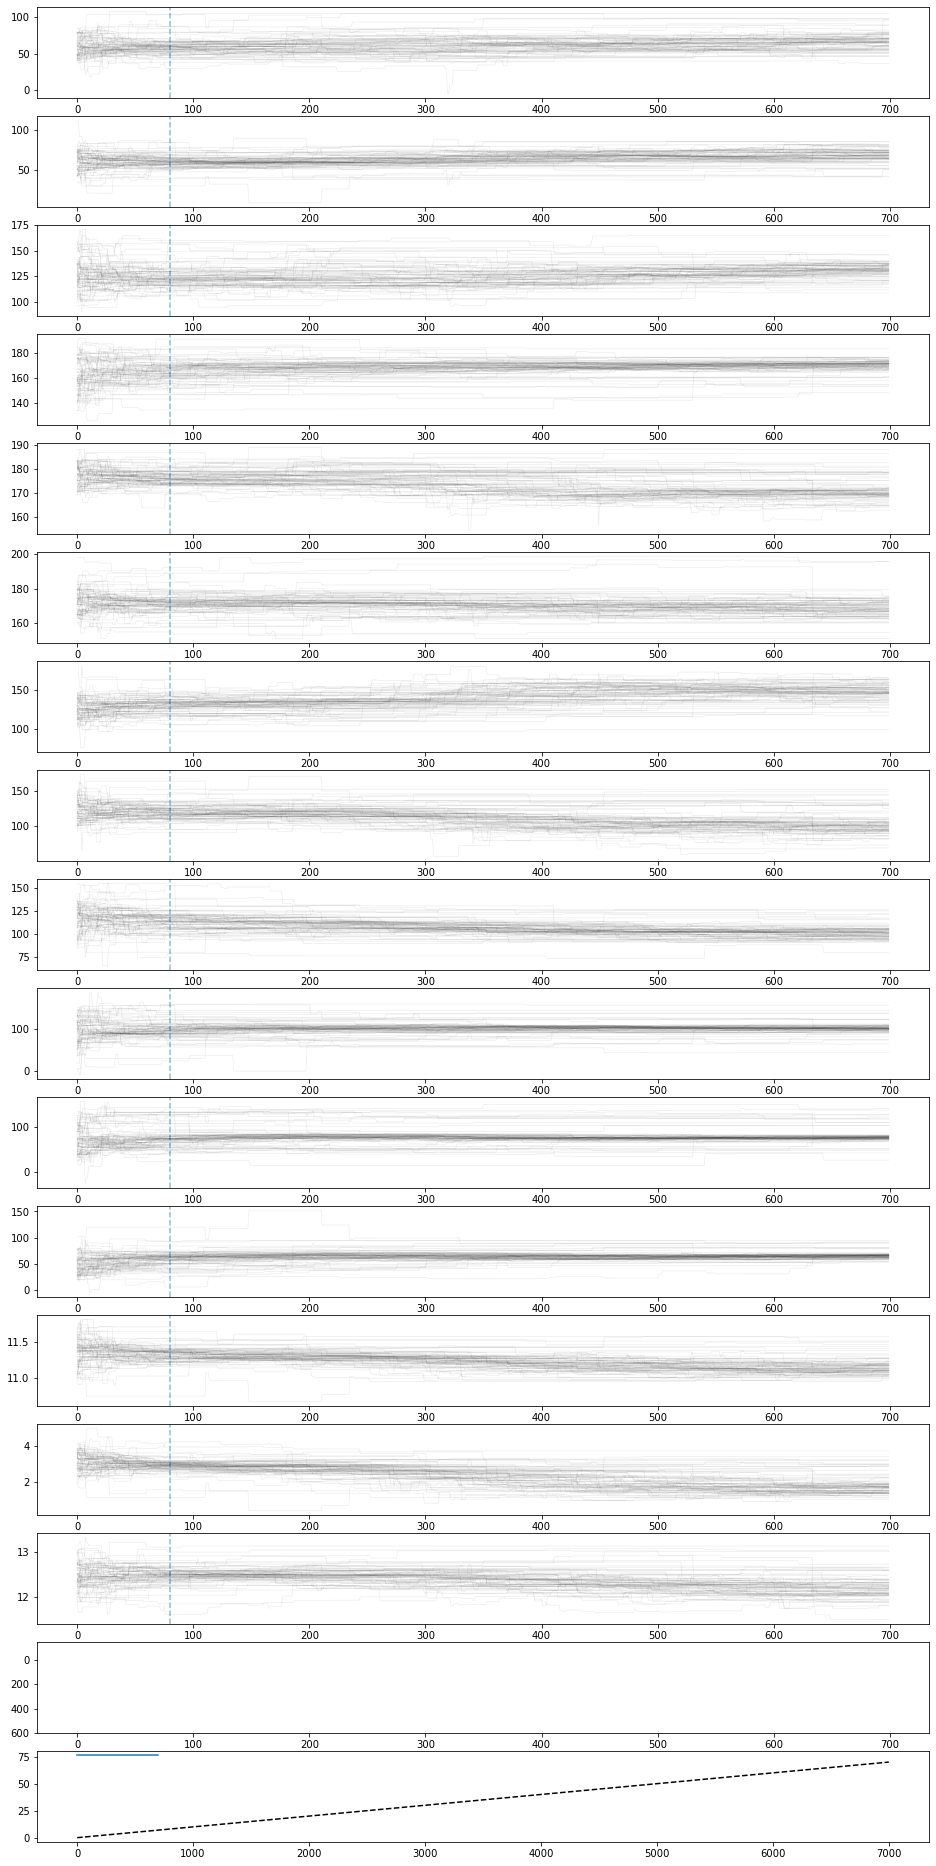

In [142]:
fig_chains,ax=plt.subplots(nrows=ndim+2,figsize=(16,2.25*ndim))
#for j in range(ndim):
#    ax[j].plot(chains[:, :, j].T,'-', alpha=0.4, color="k")
for j in range(ndim):
    ax[j].axvline(burnin,linestyle='--',alpha=0.5)
    for k in range(nwalkers):
        ax[j].plot(range(nsteps),chains[:, k, j],'-',color='k',alpha=0.075,linewidth=0.7)
    ax[-2].plot(range(nsteps),L[:,j],label=j)
ax[-2].set(ylim=[600,None])
#ax[-1].legend()
ax[-1].plot(range(nsteps),autocorr)
nn=np.linspace(0, 10*nsteps)
ax[-1].plot(nn,  nn/ 100.0, "--k")
#fig_chains.savefig(plot['savefig_chains'],bbox_inches = 'tight',pad_inches = 0)

In [143]:
Q10=np.quantile(samples,q=[0.01,0.99],axis=0)
ranges=Q10.T
fpars=six_dic['param_names']
#quantiles
Q=np.quantile(samples,q=[0.16,0.5,0.84],axis=0)
print("==== QUANTILES (16% - 50% - 84%) ====")
for fpar,q in zip(fpars,Q.T):
    print(f"Parameter {fpar} quantiles  ({q[0]:.2f} - {q[1]:.2f} - {q[2]:.2f})")

==== QUANTILES (16% - 50% - 84%) ====
Parameter pa_0.01 quantiles  (52.04 - 62.68 - 73.14)
Parameter pa_0.3 quantiles  (55.71 - 63.55 - 71.91)
Parameter pa_1.0 quantiles  (116.70 - 126.17 - 136.05)
Parameter pa_2.0 quantiles  (161.76 - 169.19 - 172.87)
Parameter pa_3.5 quantiles  (169.29 - 173.96 - 179.35)
Parameter pa_4.1 quantiles  (164.97 - 170.44 - 175.16)
Parameter i_0.01 quantiles  (126.95 - 140.42 - 154.10)
Parameter i_0.3 quantiles  (96.45 - 111.86 - 129.32)
Parameter i_1.0 quantiles  (98.13 - 105.56 - 115.08)
Parameter i_2.0 quantiles  (90.72 - 100.61 - 107.86)
Parameter i_3.5 quantiles  (67.84 - 76.56 - 92.87)
Parameter i_4.1 quantiles  (57.86 - 64.31 - 70.10)
Parameter logM quantiles  (11.11 - 11.23 - 11.35)
Parameter a quantiles  (1.52 - 2.39 - 2.97)
Parameter logMvir quantiles  (12.14 - 12.39 - 12.60)


In [156]:
blobs = sample.get_blobs()

In [158]:
nwalkers

75

In [157]:
blobs

(700, 75, 2)

(array([4.000e+00, 2.000e+00, 3.300e+01, 3.800e+01, 6.000e+01, 2.430e+02,
        4.360e+02, 8.320e+02, 2.602e+03, 4.825e+04]),
 array([-2435.2775    , -2215.82121875, -1996.3649375 , -1776.90865625,
        -1557.452375  , -1337.99609375, -1118.5398125 ,  -899.08353125,
         -679.62725   ,  -460.17096875,  -240.7146875 ]),
 <BarContainer object of 10 artists>)

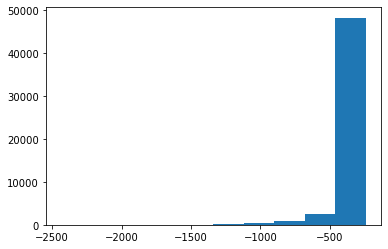

In [155]:
plt.hist(blobs[:,1])

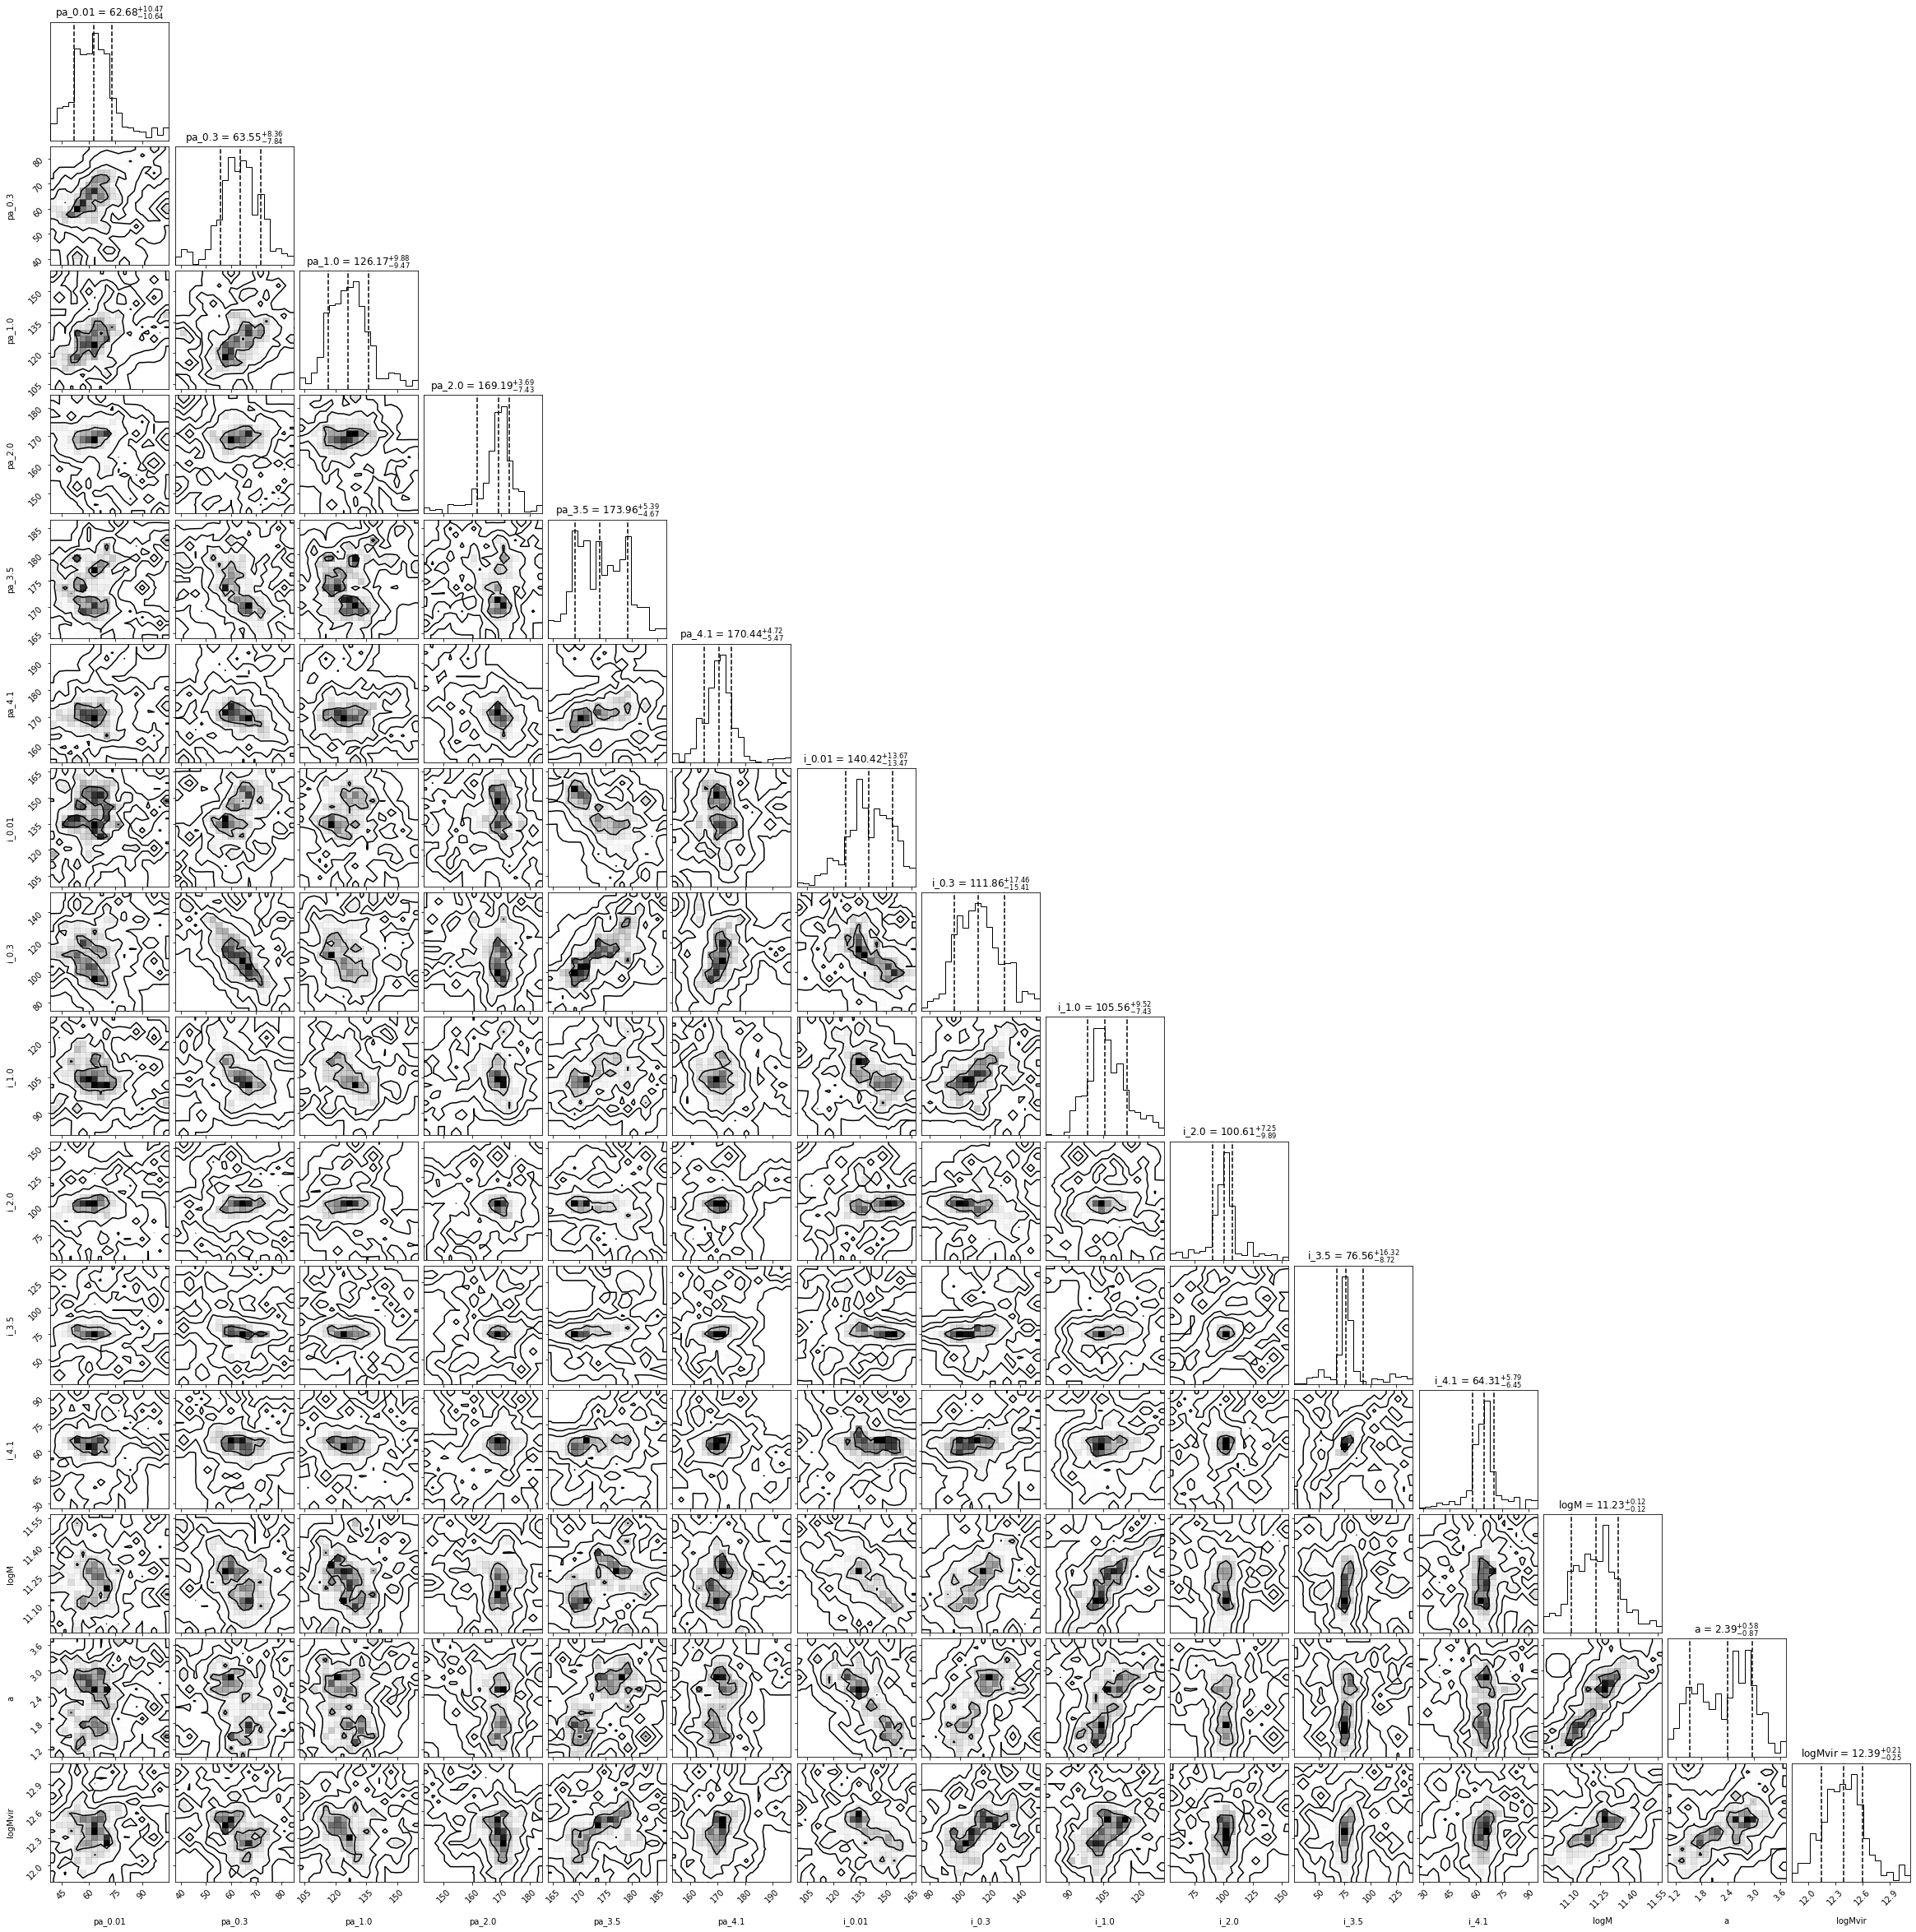

In [144]:
import corner
truths=None
smooth=0.5
sigmas=[1,2,3,5]
levels=[1-np.exp(-s**2/2) for s in sigmas]
fig = corner.corner(samples, labels=fpars,range=ranges,show_titles=True,truths=truths,quantiles=[0.16,0.5,0.84],levels=levels,smooth=smooth)

In [18]:
flag,Z,dV=get_RES(X3d,Y3d,V3d,R3d,PHI3d,params0,p_six.make_disks,R_d,dR_d,six_dic,epsilon_v=30,dV0=500,delta_v=30,da=3)

../scripts/fitters/p_six.py:74: RuntimeWarning: invalid value encountered in sqrt
  i1=np.arctan((k1*k1-1)**0.5)#np.arctan(np.sqrt(k1**2-1))


In [99]:
likelihood_V(params,X3d,Y3d,V3d,R3d,PHI3d,p_six.make_disks,R_d,dR_d,six_dic,dV0=400,delta_v=60)

122.94180555555556

In [409]:
reload(p_six)
sol=differential_evolution(likelihood_V,bounds,tol=0.1,
args=(X3d,Y3d,V3d,R3d,PHI3d,p_six.make_disks,R_d,dR_d,six_dic,400,30),
constraints=[NonlinearConstraint(p_six.HI,0., 2),NonlinearConstraint(p_six.conmM,1, 2)])

<module 'p_six' from '../scripts/fitters/p_six.py'>

In [412]:

sol

           constr: [array([0.]), array([0.])]
 constr_violation: 0.0
              fun: 491.76722222222224
            maxcv: 0.0
          message: 'Optimization terminated successfully.'
             nfev: 6800
              nit: 45
          success: True
                x: array([ 64.78110164,  73.90330113, 146.29003496, 165.68139912,
       172.4282635 , 167.45767086, 107.86423024, 143.90211973,
        98.06564895, 111.18711375,  79.68962445,  75.66274912,
        11.30062555,   2.43083984,  12.53576108])

In [93]:
N=X3d.shape[0]
dvs=[20,30,40,50,60,70,80,90,100]
post=np.array([])
for dv in dvs:  
    chi=likelihood_V(params,X3d,Y3d,V3d,R3d,PHI3d,p_six.make_disks,R_d,dR_d,six_dic,dV0=400,delta_v=dv)
    post=np.append(post,chi+0.5*N*np.log(2*np.pi*dv**2))

../scripts/fitters/p_six.py:74: RuntimeWarning: invalid value encountered in sqrt
  i1=np.arctan((k1*k1-1)**0.5)#np.arctan(np.sqrt(k1**2-1))


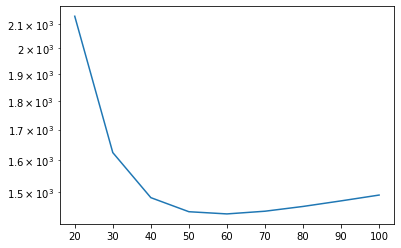

In [95]:
plt.semilogy(dvs,post)

In [23]:
def plot_residuals(X,Y,A,dV,params,R_d,dR_d,disks_f,dic,cube=None,xlim=[-1.4,1.4],ylim=[-4,4],dvmin=0,dvmax=1000):
    mosaic= [['dV','A_res']]
    gridspec_kw={'width_ratios': [1,1],'height_ratios': [1]}
    fig = plt.figure(constrained_layout=False,figsize=(16,11))
    ax = fig.subplot_mosaic(mosaic,gridspec_kw=gridspec_kw)
    divider = make_axes_locatable(ax['dV'])
    caxdV = divider.append_axes("top", size="2.5%", pad=0.05)
    Vlims=(np.abs(dV)>dvmin)&(np.abs(dV)<dvmax)
    cm=ax['dV'].scatter(X[Vlims],Y[Vlims],marker='o',c=dV[Vlims],vmin=-350,vmax=350,cmap='seismic',alpha=0.5)
    ax['dV'].set(aspect=1,xlabel='x',ylabel='y',xlim=xlim,ylim=ylim)
    plt.colorbar(cm,cax=caxdV,orientation='horizontal',fraction=0.046,pad=0.04).ax.tick_params(labelsize=9)
    caxdV.xaxis.set_ticks_position("top")
    #
    divider = make_axes_locatable(ax['A_res'])
    caxA = divider.append_axes("top", size="2.5%", pad=0.05)
    cmA=ax['A_res'].scatter(X[Vlims],Y[Vlims],marker='o',c=A[Vlims],norm=LogNorm(),cmap='magma',alpha=0.3)
    plt.colorbar(cmA,cax=caxA,orientation='horizontal',fraction=0.046,pad=0.04).ax.tick_params(labelsize=9)
    caxA.xaxis.set_ticks_position("top")
    
    phis=np.linspace(0,2*np.pi,800)
    R_d2,I_d,Phi_d,Vc_d,tani2s,vsinis,tanI12,tanI22=disks_f(params,R_d,dR_d,dic)
    for m,(rd,vcd,i_d,phi_d) in enumerate(zip(R_d2,Vc_d,I_d,Phi_d)):
        Rd_sky=rd/(1+np.tan(i_d)**2*np.cos(phis-phi_d)**2)**0.5
        xd=Rd_sky*np.cos(phis)
        yd=Rd_sky*np.sin(phis)
        ax['A_res'].plot(xd,yd,alpha=0.25)

    ax['A_res'].set(aspect=1,xlabel='x',ylabel='y',xlim=xlim,ylim=ylim)
    if cube is not None:
        ax['A_res'].pcolormesh(cube.x,cube.y,np.nansum(cube['cube'].data,axis=0))

# Results

In [20]:
params=np.array([ 64.78110164,  73.90330113, 146.29003496, 165.68139912,
       172.4282635 , 167.45767086, 107.86423024, 143.90211973,
        98.06564895, 111.18711375,  79.68962445,  75.66274912,
        11.30062555,   2.43083984,  12.53576108])#sol.x

In [21]:

flag,Z,dV=get_RES(X3d,Y3d,V3d,R3d,PHI3d,params,p_six.make_disks,R_d,dR_d,six_dic,epsilon_v=30,dV0=500,delta_v=30,da=3)

../scripts/fitters/p_six.py:74: RuntimeWarning: invalid value encountered in sqrt
  i1=np.arctan((k1*k1-1)**0.5)#np.arctan(np.sqrt(k1**2-1))


/home/astromix/miniconda3/envs/MAYA/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


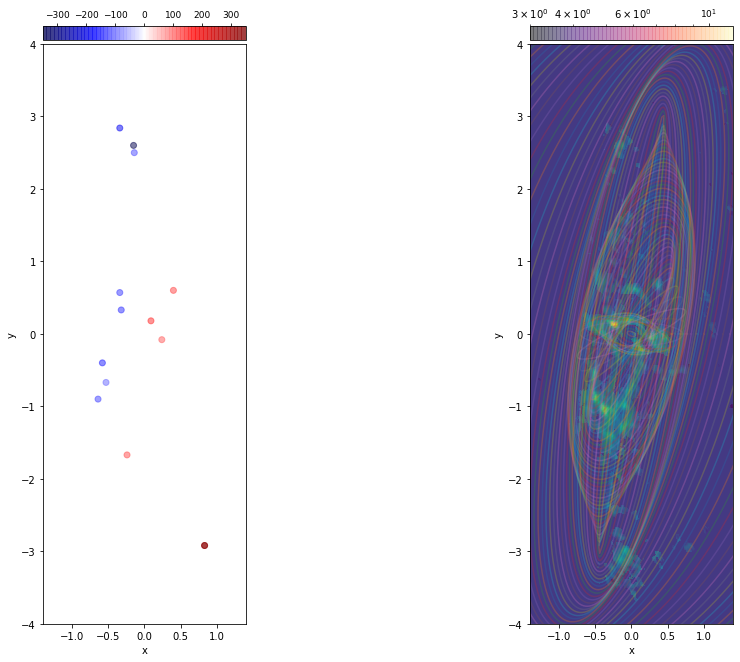

In [24]:
plot_residuals(X3d,Y3d,A3d,dV,params,R_d,dR_d,p_six.make_disks,six_dic,cube=CO21,xlim=[-1.4,1.4],ylim=[-4,4],dvmin=100,dvmax=1000)

In [25]:
import viz

## Geometry

../scripts/fitters/p_six.py:74: RuntimeWarning: invalid value encountered in sqrt
  i1=np.arctan((k1*k1-1)**0.5)#np.arctan(np.sqrt(k1**2-1))


[[Model]]
    Model(_warp)
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 167
    # data points      = 76
    # variables        = 3
    chi-square         = 73462.5668
    reduced chi-square = 1006.33653
    Akaike info crit   = 528.408642
    Bayesian info crit = 535.400842
[[Variables]]
    ephi:    0.1 (fixed)
    theta0:  88.0449262 +/- 40.4675071 (45.96%) (init = 80)
    theta1:  254.932119 +/- 1.64743978 (0.65%) (init = 80)
    T:       1020.50523 +/- 21116.3255 (2069.20%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(theta0, T) =  1.000


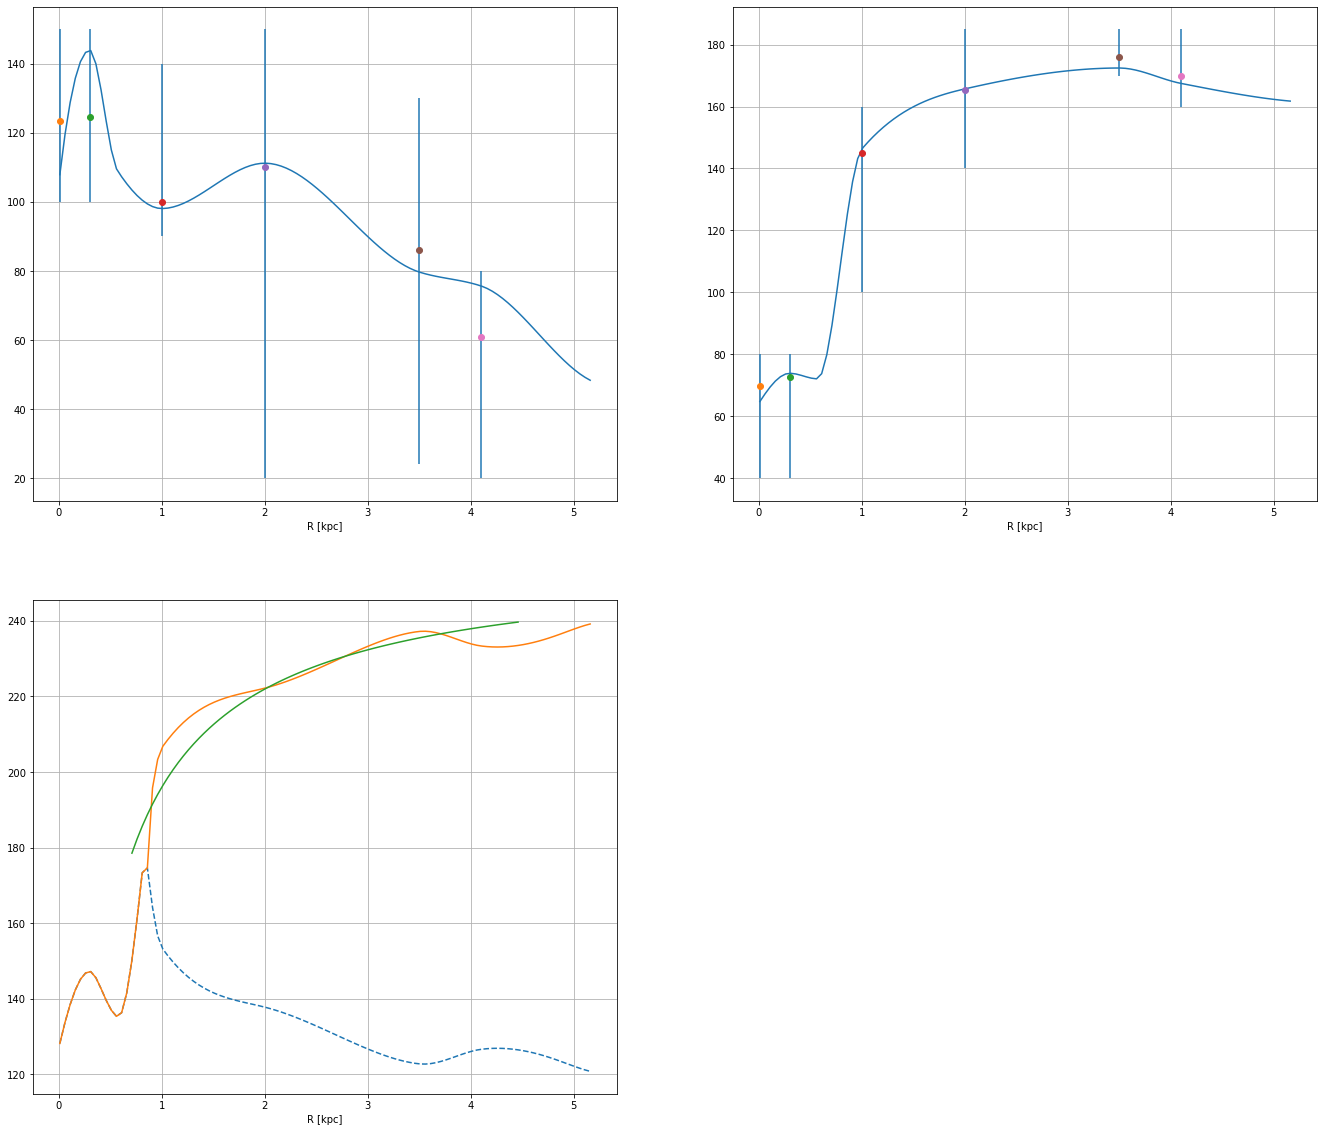

In [26]:
%matplotlib inline

reload(viz)
wfit={'param_hints':{'ephi':{'value':0.1,'min':0.02,'max':1,'vary':False},
      'theta0':{'value':80,'min':0,'max':280,'vary':True},
      'theta1':{'value':80,'min':0,'max':280,'vary':True},
      'T':{'value':1000,'min':800.,'max':1500,'vary':True}
      },
      'R1':0.7,'R2':4.5
     }

viz.results(params,p_six.make_disks,R_d,dR_d,six_dic,bounds=six_dic['bounds'],params0=six_dic['params0'],
            galaxy={'R':0.2,'i':20,'pa':120},fix_arccos=0.9,warp_fit=wfit)

## Rot Velocity

17.184445773843976 2.43083984


../scripts/fitters/p_six.py:51: RuntimeWarning: divide by zero encountered in true_divide
  return (G*Mbh/r + (G*10**logM *r)/(r+a)**2 +VNFW(r,10**logMvir,c)**2)**0.5
../scripts/fitters/p_six.py:48: RuntimeWarning: invalid value encountered in true_divide
  np.log(c+1.)))**0.5/R**0.5)


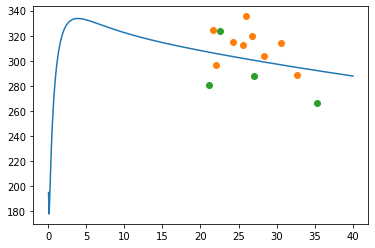

In [27]:
Rc=21
logM=params[12]
a=params[13]
logMvir=params[14]
print(10**(logMvir-logM),a)

c=six_dic['params_dic']['c']
RR=np.linspace(0,40,660)
plt.plot(RR,p_six.Vcirc(RR,six_dic['params_dic']['Mbh'],logM,a, logMvir,c))
plt.plot(Rvcf,Vvcf,'o')
plt.plot(Rmf,Vmf,'o')

## PVD

../scripts/fitters/p_six.py:74: RuntimeWarning: invalid value encountered in sqrt
  i1=np.arctan((k1*k1-1)**0.5)#np.arctan(np.sqrt(k1**2-1))
../src/viz.py:179: RuntimeWarning: invalid value encountered in true_divide
  pvd_cube=cubeslice/pvdmadmap;  #pvdlvs[0]
../src/viz.py:179: RuntimeWarning: invalid value encountered in true_divide
  pvd_cube=cubeslice/pvdmadmap;  #pvdlvs[0]


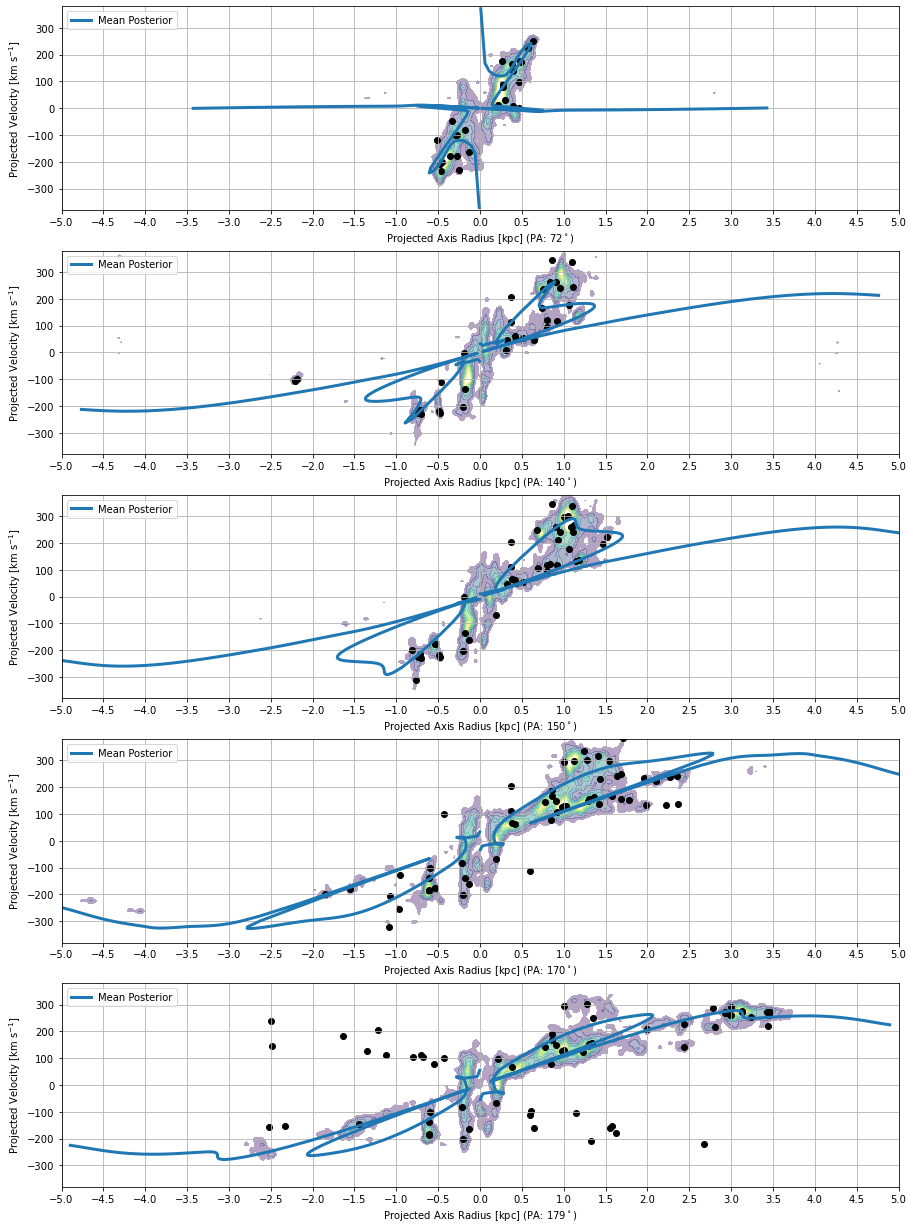

In [421]:
reload(viz)
viz.resultspvd_bay(CO21_total,params,p_six.make_disks,R_d,dR_d,six_dic,X3d,Y3d,V3d,A3d,[72,140,150,170,179],slit=0.25,figsize='auto')

In [36]:
Sx3d.shape

(322,)

In [35]:
np.max([Sx3d,Sy3d],axis=0).shape

(322,)

In [50]:
def plot3d(params,X,Y,Z,dV,A,Sx,Sy,disks_f,dic,R_d,dR_d,show='model',views=[[0,-90],[80,120],[80,162]],
           animation=False,axsize=12,lim=[-5,5],limdv=100):
    if animation:
        fig = plt.figure(figsize=(axsize*0.7,axsize),tight_layout=True)
        ax = fig.add_subplot(1,1,1, projection='3d')
    else:
        fig = plt.figure(figsize=(axsize*len(views)*0.7,axsize),tight_layout=True)
    for n,view in enumerate(views):
        if not animation: ax = fig.add_subplot(1,len(views),n+1, projection='3d')
        if show=='model':
            ax.scatter(X,Y,Z,marker='o',c=A,norm=LogNorm(),cmap='magma',alpha=0.5)
        elif show=='res':
            ax.scatter(X,Y,Z,marker='o',s=np.max([Sx,Sy],axis=0)*600,c=A,norm=LogNorm(),cmap='magma',alpha=0.5)
        elif show=='resV':
            FF=(np.abs(dV)>limdv)&(np.abs(dV)<1000)
            ax.scatter(X[FF],Y[FF],Z[FF],marker='o',c=dV[FF],cmap='seismic',alpha=0.5)
        elif show=='3d':
            phi = np.linspace(0,2*np.pi, 128).reshape(128, 1) # the angle of the projection in the xy-plane
            theta = np.linspace(0, np.pi, 128).reshape(-1, 128) # the angle from the polar axis, ie the polar angle
            for x,y,z,sx,sy in zip(X,Y,Z,Sx,Sy):
                # Transformation formulae for a spherical coordinate system.

                Rmax=np.max([sx,sy])
                xx = sx*np.sin(theta)*np.cos(phi)*Rmax
                yy = sy*np.sin(theta)*np.sin(phi)*Rmax
                zz = 0.1*np.cos(theta)*Rmax
                ax.plot_surface(xx+x,yy+y,zz+z,alpha=0.6)
        else:
            ax.scatter(X,Y,Z,marker='o',c=A,rm=LogNorm(),cmap='magma',alpha=0.5)
        R_d,I_d,Phi_d,Vc_d,tani2s,vsinis,tanI12,tanI22=disks_f(params,R_d,dR_d,dic)
        xells=np.array([])
        yells=np.array([])
        zells=np.array([])
        phis=np.linspace(0,2*np.pi,1000)
        for m,(rd,vcd,i_d,phi_d) in enumerate(zip(R_d,Vc_d,I_d,Phi_d)):
            rell= rd/np.sqrt(1+np.tan(i_d)**2*np.cos(phis-phi_d)**2)
            xell=rell*np.cos(phis)
            yell=rell*np.sin(phis)
            zell = -np.tan(i_d)*(xell*np.cos(phi_d)+yell*np.sin(phi_d))
            ax.plot(xell,yell,zell,color='grey',alpha=0.2)
        ax.view_init(-view[0]+90,view[1])
        ax.set(xlim=lim,ylim=lim,zlim=lim,xlabel='x',ylabel='y',zlabel='z')

## 3D

In [51]:
%matplotlib qt
views=[[0,-90]]#[[0,-90],[80,120],[80,162]]
plot3d(params,X3d,Y3d,Z,dV,A3d,Sx3d,Sy3d,p_six.make_disks,six_dic,R_d,dR_d,show='res',views=views,limdv=100,
           animation=False,lim=[-5,5],axsize=10)

../scripts/fitters/p_six.py:74: RuntimeWarning: invalid value encountered in sqrt
  i1=np.arctan((k1*k1-1)**0.5)#np.arctan(np.sqrt(k1**2-1))
/home/astromix/miniconda3/envs/MAYA/lib/python3.7/site-packages/ipykernel/eventloops.py:106: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  app.exec_()


In [59]:
det

array([ 8.73093975e+00,  1.71296347e+01, -1.30005150e+00, -2.21599612e+01,
       -1.37478767e+01, -1.65644475e+00, -7.35682853e+02,  1.53704267e+00,
        5.47865250e-01, -4.08001590e+02,  3.02350895e+00, -8.58222432e-01,
       -2.40313185e+01, -6.61043500e+00, -6.22955878e+02, -2.75985198e+01,
        3.04563548e+00,  5.74502721e-01,  2.66667500e-01,  8.43018750e-01,
        4.85142900e+00, -7.78786218e+01,  2.09237929e+00, -2.58212333e-01,
       -1.00361223e+01, -3.25573163e+00, -8.00280000e-01, -2.46124750e-01,
       -9.74121724e-01, -3.34037986e+00, -7.77780014e-01, -9.61393832e+00,
       -2.88798532e+01, -1.72887563e+01, -5.94785379e+01,  7.06386905e+00,
       -5.02230332e+01, -6.43919369e+01,  1.96813693e+00, -8.70695160e-03,
       -1.63170985e+02,  1.03259076e+00,  1.85571000e-01,  9.05028507e-02,
        2.65593139e+00, -2.38983424e+01,  1.08568889e+01,  1.11028700e+01,
       -1.19263221e+01, -4.78133218e+00,  7.33730988e+00, -2.56111038e+01,
       -9.44724469e+01,  

In [58]:
det=(a3d*c3d-b3d**2)/Sv3d**2
np.sqrt((2*np.pi**3)/det)

/home/astromix/miniconda3/envs/MAYA/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


array([  2.66507424,   1.90268001,          nan,          nan,
                nan,          nan,          nan,   6.35180044,
        10.63905195,          nan,   4.5288108 ,          nan,
                nan,          nan,          nan,          nan,
         4.51232992,  10.38947882,  15.24947043,   8.57671916,
         3.57523808,          nan,   5.4440186 ,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,   2.96291019,
                nan,          nan,   5.61322113,          nan,
                nan,   7.74953581,  18.28036037,  26.1763252 ,
         4.83204957,          nan,   2.38994061,   2.3633181 ,
                nan,          nan,   2.90717635,          nan,
                nan,   9.18938785,   3.0382603 ,   1.91294534,
         5.39391219,          nan,   3.03956101,          nan,
                nan,          nan,   4.55749552,       

In [53]:
R3d.shape

(262,)

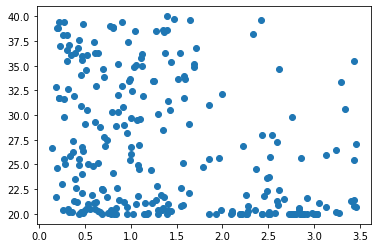

In [55]:
%matplotlib inline
plt.plot(R3d,Sv3d,'o')